## Download and preprocess drug response data from GDSC

* Drug responses come from processed data in [Sharifi-Noghabi et al. 2019](https://doi.org/10.1093/bioinformatics/btz318)
* Cell lines are binarized into resistant/sensitive for each drug as described in [Iorio et al. 2016](https://doi.org/10.1016/j.cell.2016.06.017) (see Table S5 and associated supplementary details)

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

In [2]:
# drug to visualize sample proportions for
# valid drugs: 5-Fluorouracil, Afatinib, Bortezomib, Cetuximab, Cisplatin, Docetaxel,
# EGFRi, Erlotinib, Gefitinib, Gemcitabine, Lapatinib, Paclitaxel, Tamoxifen
drug_name = 'EGFRi'

# where to save plots
output_plots = True
output_plots_dir = (
    cfg.repo_root / '08_cell_line_prediction' / 'drug_response_dists'
)
output_plots_dir.mkdir(exist_ok=True)

### Download drug response data

In [3]:
drug_response_file = cfg.cell_line_drug_response / 'response.tar.gz'
decompress_dir = cfg.cell_line_drug_response / 'raw_response'

if not os.path.exists(drug_response_file):
    cfg.cell_line_drug_response.mkdir(exist_ok=True)
    
    # retrieve compressed response data
    from urllib.request import urlretrieve
    url = 'https://zenodo.org/record/4036592/files/response.tar.gz?download=1'
    urlretrieve(url, drug_response_file)
    
    # decompress response data
    decompressed_location = cfg.cell_line_drug_response / 'response'
    !tar -xvzf $drug_response_file -C $cfg.cell_line_drug_response
    !mv $decompressed_location $decompress_dir
else:
    print('Downloaded response data from MOLI paper already exists, skipping download')

Downloaded response data from MOLI paper already exists, skipping download


### Load CCLE sample info

In [4]:
ccle_sample_info_df = pd.read_csv(cfg.ccle_sample_info, sep=',', index_col=0)
ccle_expression_samples_df = pd.read_csv(cfg.ccle_expression, sep=',',
                                         index_col=0, usecols=[0])

In [5]:
print(ccle_sample_info_df.columns)
ccle_sample_info_df.iloc[:5, :5]

Index(['cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias',
       'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')


,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID
DepMap_ID,,,,,
ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN
ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN
ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN
ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN
ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN


In [6]:
ccle_expression_samples_df.head()

""
ACH-001113
ACH-001289
ACH-001339
ACH-001538
ACH-000242


In [7]:
ccle_samples = ccle_expression_samples_df.index.intersection(ccle_sample_info_df.index)
ccle_to_cosmic_id = (ccle_sample_info_df
    .reindex(ccle_samples)
    .COSMICID
    .dropna()
    .astype(int)
)

print(ccle_samples.shape,ccle_to_cosmic_id.shape)
ccle_to_cosmic_id[:5]

(1406,) (700,)


ACH-000242     687455
ACH-000708    1659929
ACH-000327     684681
ACH-000233     906836
ACH-000528     906791
Name: COSMICID, dtype: int64

In [8]:
ccle_cancer_types = (ccle_sample_info_df
    .reindex(ccle_samples)
    .groupby('primary_disease')
    .count()
    .reset_index()
    .iloc[:, [0, 1]]
    .rename(columns={'cell_line_name': 'count'})
)

ccle_cancer_types.head()

,primary_disease,count
0,Adrenal Cancer,1
1,Bile Duct Cancer,35
2,Bladder Cancer,36
3,Bone Cancer,38
4,Brain Cancer,80


### Check distribution of labeled samples across cancer types

In [9]:
drug_response_df = pd.read_csv(
    decompress_dir / 'GDSC_response.{}.tsv'.format(drug_name), sep='\t'
)

print(drug_response_df.shape)
drug_response_df.head()

(3258, 7)


,sample_name,response,logIC50,drug,exprs,CNA,mutations
0,683665,R,6.294447,Cetuximab,1,1,1
1,683665,R,2.436586,Erlotinib,1,1,1
2,683665,R,2.684181,Lapatinib,1,1,1
3,683665,R,1.464855,Gefitinib,1,1,1
4,683665,R,1.490015,Afatinib,1,1,1


In [10]:
ccle_drug_label_overlap = (
    set(drug_response_df.sample_name).intersection(
    set(ccle_to_cosmic_id.values))
)
    
print(len(ccle_drug_label_overlap))
print(list(ccle_drug_label_overlap)[:5])

667
[907269, 907270, 907271, 907273, 907274]


In [11]:
ccle_label_cancer_types = (ccle_sample_info_df
    [ccle_sample_info_df.COSMICID.isin(ccle_drug_label_overlap)]
    .groupby('primary_disease')
    .count()
    .reset_index()
    .iloc[:, [0, 1]]
    .rename(columns={'cell_line_name': 'labeled_count'})
    .merge(ccle_cancer_types, how='right', on='primary_disease')
    .fillna(value=0)
)

ccle_label_cancer_types['labeled_proportion'] = (
    ccle_label_cancer_types['labeled_count'] / ccle_label_cancer_types['count']
)

ccle_label_cancer_types.head()

,primary_disease,labeled_count,count,labeled_proportion
0,Adrenal Cancer,1.0,1,1.000000
1,Bile Duct Cancer,2.0,35,0.057143
2,Bladder Cancer,16.0,36,0.444444
3,Bone Cancer,15.0,38,0.394737
4,Brain Cancer,39.0,80,0.487500


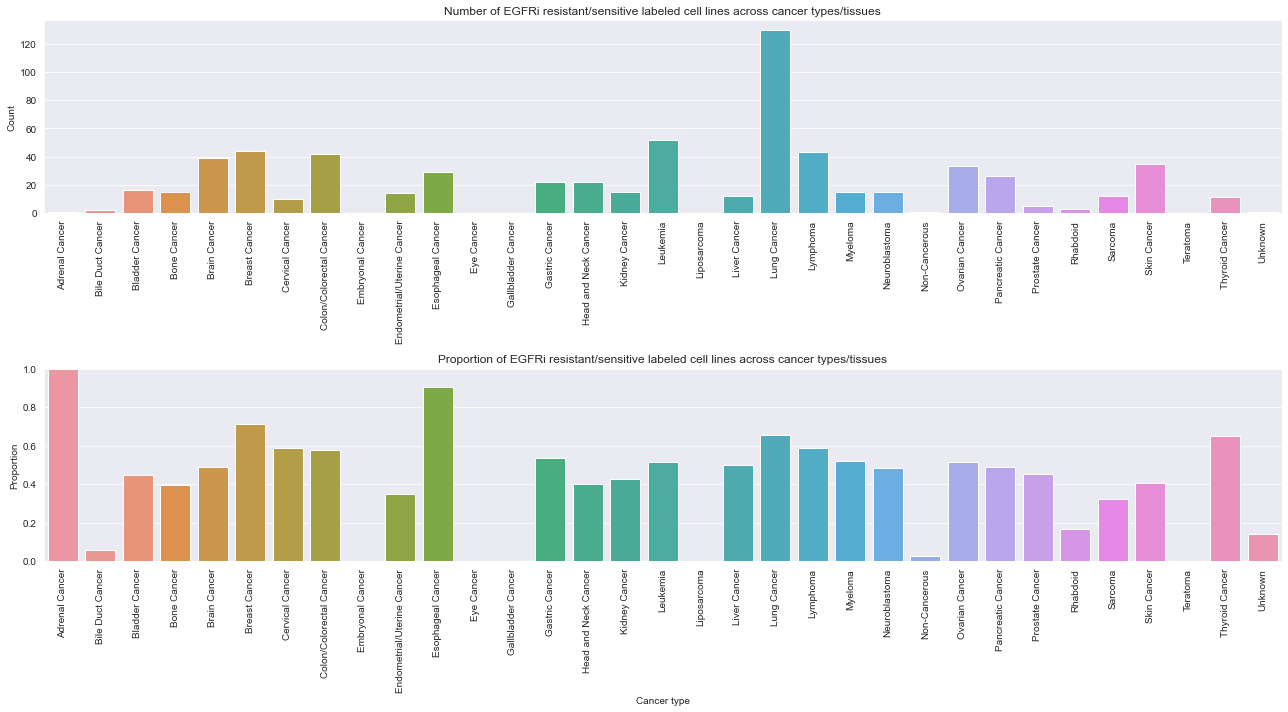

In [12]:
sns.set({'figure.figsize': (18, 10)})
fig, axarr = plt.subplots(2, 1)

sns.barplot(data=ccle_label_cancer_types, x='primary_disease',
            y='labeled_count', ax=axarr[0])
axarr[0].set_xticklabels(axarr[0].get_xticklabels(), rotation=90)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Count')
axarr[0].set_title(
    'Number of {} resistant/sensitive labeled cell lines across cancer types/tissues'.format(
        drug_name)
)

sns.barplot(data=ccle_label_cancer_types, x='primary_disease',
            y='labeled_proportion', ax=axarr[1])
axarr[1].set_xticklabels(axarr[1].get_xticklabels(), rotation=90)
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('Proportion')
axarr[1].set_ylim(0.0, 1.0)
axarr[1].set_title(
    'Proportion of {} resistant/sensitive labeled cell lines across cancer types/tissues'.format(
        drug_name)
)

plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / '{}_dist.png'.format(drug_name),
                dpi=200, bbox_inches='tight')